In [11]:
import cvxpy as cp
import mosek 
# Mosek is a commercial solver, free for academic use
# Open-source alternatives are also available, see https://www.cvxpy.org/tutorial/solvers/index.html#choosing-a-solver
import numpy as np

# Plotting packages and parameters
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
%matplotlib inline

plt.rc('text', usetex=True)
mpl.rcParams['text.usetex'] = True
plt.rcParams['lines.linewidth'] = 1.3
plt.rcParams['figure.constrained_layout.use'] = True
mpl.rcParams['pgf.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}'

# Function definitions

In [3]:
def matrix_to_vector(matrix):
    # Use list comprehension to flatten the matrix column by column
    vector = [element for column in zip(*matrix) for element in column]
    return vector

def vector_to_matrix(vector):
    # Calculate the number of rows as half the dimension of the vector
    num_rows = int(np.sqrt(len(vector)))
    
    # Use list comprehension to reshape the vector back to a matrix
    matrix = [vector[i:i + num_rows] for i in range(0, len(vector), num_rows)]

    matrix = np.transpose(matrix)

    return matrix

def CentralBasisVector(A1,A2,rmean): # return a single vector (X1 , vecX2)
    X2=A2
    X1=A1+2*np.dot(A2,rmean)
    X2vec = matrix_to_vector(X2)
    X12vec = np.concatenate((X1,X2vec))
    return X12vec

def RLDCentralBasisVector(A1,A2,rmean): # return a single vector (X1 , vecX2)
    X2=A2
    X1=A1+np.dot(A2,rmean)+np.dot(A2.T,rmean)
    X2vec = matrix_to_vector(X2)
    X12vec = np.concatenate((X1,X2vec))
    return X12vec

### $C_\theta^\mathrm{S}$ and $C_\theta^\mathrm{R}$  bounds by computing SLD and RLD operators

In [5]:
def SLD_Gaussian(rmean,sigma,drmean,dsigma): 
#this function gives back the SLD operators, in terms of the matrices, vectors and scalar L2, L1, L0
    
    vecsigma=matrix_to_vector(sigma)
    vecdsigma=matrix_to_vector(dsigma)

    d = sigma.shape[0] // 2  # number of modes    

    Omega1 = np.array([[0, 1], [-1, 0]]) 

    Omega = Omega1
    if d > 1:
        for jj in range(d-1):
            Omega=np.block([[Omega, np.zeros((Omega.shape[0], Omega1.shape[1]))],
                       [np.zeros((Omega1.shape[0], Omega.shape[1])), Omega1]])
    
    vecOmega= matrix_to_vector(Omega)


    Mat = np.kron(sigma,sigma) - np.kron(Omega,Omega)  
    abs_det = abs(np.linalg.det(Mat))

    tol=1e-8; #tolerance for considering the matrix invertible
    if abs_det >tol:
        Mat = np.linalg.inv(Mat)
    else:
        Mat = np.linalg.pinv(Mat)   

    dsigmavec = matrix_to_vector(dsigma)
    vecL2 = np.dot(Mat,dsigmavec)
    
    L2Matrix = vector_to_matrix(vecL2)

    L1 = 2 * np.dot(np.linalg.inv(sigma),drmean) - 2 * np.dot(L2Matrix,rmean)
    
    L0 = - np.trace(np.dot(sigma,L2Matrix))/2 - np.dot(np.transpose(L1),rmean) - np.dot(np.transpose(rmean),np.dot(L2Matrix,rmean))

    return L0,L1,vecL2

def RLD_Gaussian(rmean,sigma,drmean,dsigma): 
#this function gives back the RLD matrices,vectors and number LR2, LR1, LR0
    
    vecsigma=matrix_to_vector(sigma)
    vecdsigma=matrix_to_vector(dsigma)

    d = sigma.shape[0] // 2  # number of modes    

    Omega1 = np.array([[0, 1], [-1, 0]]) 

    Omega = Omega1
    if d > 1:
        for jj in range(d-1):
            Omega=np.block([[Omega, np.zeros((Omega.shape[0], Omega1.shape[1]))],
                       [np.zeros((Omega1.shape[0], Omega.shape[1])), Omega1]])
    
    vecOmega= matrix_to_vector(Omega)

    Mat1 = sigma - 1j * Omega 
    abs_det = abs(np.linalg.det(Mat1))

    tol=1e-8; #tolerance for considering the matrix invertible
    if abs_det >tol:
        Mat1 = np.linalg.inv(Mat1)
    else:
        Mat1 = np.linalg.pinv(Mat1)   

    Mat2 = sigma + 1j * Omega 
    abs_det = abs(np.linalg.det(Mat2))

    tol=1e-8; #tolerance for considering the matrix invertible
    if abs_det >tol:
        Mat2 = np.linalg.inv(Mat2)
    else:
        Mat2 = np.linalg.pinv(Mat2)   
    
    CH=np.dot(Mat1,dsigma)
    LR2=np.dot(CH,Mat2)
    LR1=2*np.dot(Mat1,drmean)-2*np.dot(LR2,rmean)
    LR0=-np.trace(np.dot((sigma - 1j * Omega),LR2))/2-np.dot(LR1.T,rmean)-np.matmul(np.matmul(rmean.T,LR2),rmean)
    vecLR2 = matrix_to_vector(LR2)
    return LR0,LR1,vecLR2

def gauss_SLDB(sigma, rmean, dsigma, drmean, npar, W, tol=1.0e-8):
    d = sigma.shape[0] // 2  # number of modes

    Omega1 = np.array([[0, 1], [-1, 0]]) 

    Omega = Omega1
    if d > 1:
        for jj in range(d-1):
            Omega=np.block([[Omega, np.zeros((Omega.shape[0], Omega1.shape[1]))],
                       [np.zeros((Omega1.shape[0], Omega.shape[1])), Omega1]])

    SOMat = sigma + 1j * Omega

    SOmatTensor = np.kron(SOMat,SOMat)
    
    SGauss = 0.5*np.block([[SOMat, np.zeros((SOMat.shape[0], SOmatTensor.shape[1]))],
                       [np.zeros((SOmatTensor.shape[0], SOMat.shape[1])), SOmatTensor]])

    fulldim = SGauss.shape[0]

    LXmat = np.zeros((fulldim, npar))
    for i in range(npar):
        L0,L1,vecL2 = SLD_Gaussian(rmean,sigma,drmean[:,i],dsigma[:, :, i])
        L2 = vector_to_matrix(vecL2)
        LXmat[:, i] = CentralBasisVector(L1,L2,rmean)

    Q = LXmat.T @ np.real(SGauss) @ LXmat
        
    sldCRB = np.trace( np.linalg.inv(Q) @ W)

    return sldCRB

def gauss_RLDB(sigma, rmean, dsigma, drmean, npar, W, tol=1.0e-8):
    d = sigma.shape[0] // 2  # number of modes

    Omega1 = np.array([[0, 1], [-1, 0]]) 

    Omega = Omega1
    if d > 1:
        for jj in range(d-1):
            Omega=np.block([[Omega, np.zeros((Omega.shape[0], Omega1.shape[1]))],
                       [np.zeros((Omega1.shape[0], Omega.shape[1])), Omega1]])

    SOMat = sigma - 1j * Omega

    SOmatTensor = np.kron(SOMat,SOMat)
    
    SGauss = 0.5*np.block([[SOMat, np.zeros((SOMat.shape[0], SOmatTensor.shape[1]))],
                       [np.zeros((SOmatTensor.shape[0], SOMat.shape[1])), SOmatTensor]])

    fulldim = SGauss.shape[0]

    LXmat = np.zeros((fulldim, npar),dtype = 'complex_') 
    #here I had to add the "complex" type as in this case the RLD operators is going to have complex values
    for i in range(npar):
        LR0,LR1,vecLR2 = RLD_Gaussian(rmean,sigma,drmean[:,i],dsigma[:, :, i])
        LR2 = vector_to_matrix(vecLR2)
        LXmat[:, i] = RLDCentralBasisVector(LR1,LR2,rmean)

    J = LXmat.T.conj() @ SGauss @ LXmat
    Jinv=np.linalg.inv(J)
    Jinvre=np.real(Jinv)
    Jinvim=np.imag(Jinv)
    Jinvimabs=scipy.linalg.sqrtm(np.dot(Jinvim,Jinvim.T.conj()))
    rldB=np.trace(Jinvre)+np.trace(Jinvimabs)
             
    return rldB

### Upper bound $\overline{C}^{\mathrm{H}}_\theta$ on the HCRB computed from SLD operators

In [6]:
def gauss_upper(sigma, rmean, dsigma, drmean, npar, W, tol=1.0e-8):
    d = sigma.shape[0] // 2  # number of modes

    Omega1 = np.array([[0, 1], [-1, 0]]) 

    Omega = Omega1
    if d > 1:
        for jj in range(d-1):
            Omega=np.block([[Omega, np.zeros((Omega.shape[0], Omega1.shape[1]))],
                       [np.zeros((Omega1.shape[0], Omega.shape[1])), Omega1]])

    SOMat = sigma + 1j * Omega

    SOmatTensor = np.kron(SOMat,SOMat)
    
    SGauss = 0.5*np.block([[SOMat, np.zeros((SOMat.shape[0], SOmatTensor.shape[1]))],
                       [np.zeros((SOmatTensor.shape[0], SOMat.shape[1])), SOmatTensor]])

    fulldim = SGauss.shape[0]

    LXmat = np.zeros((fulldim, npar))
    for i in range(npar):
        L0,L1,vecL2 = SLD_Gaussian(rmean,sigma,drmean[:,i],dsigma[:, :, i])
        L2 = vector_to_matrix(vecL2)
        LXmat[:, i] = CentralBasisVector(L1,L2,rmean)

    Q = LXmat.T @ np.real(SGauss) @ LXmat
    D = LXmat.T @ np.imag(SGauss) @ LXmat
    temp = scipy.linalg.sqrtm(W) @ np.linalg.inv(Q)@ D @ np.linalg.inv(Q)@ scipy.linalg.sqrtm(W)
        
    correction = np.trace(scipy.linalg.sqrtm(np.dot(temp,temp.T.conj())))
        
    sldCRB = np.trace( np.linalg.inv(Q) @ W)
    upper = sldCRB+correction
    

    return upper 

### HCRB $C_{\theta}^{\mathrm{H}}$ by solving a SDP

In [7]:
def gauss_hcrb_SDP(sigma, rmean, dsigma, drmean, npar, W, tol=1.0e-8):
    d = sigma.shape[0] // 2  # number of modes

    Omega1 = np.array([[0, 1], [-1, 0]]) 

    Omega = Omega1
    if d > 1:
        for jj in range(d-1):
            Omega=np.block([[Omega, np.zeros((Omega.shape[0], Omega1.shape[1]))],
                       [np.zeros((Omega1.shape[0], Omega.shape[1])), Omega1]])

    SOMat = sigma - 1j * Omega

    SOmatTensor = np.kron(SOMat,SOMat)
    
    SGauss = 0.5*np.block([[SOMat, np.zeros((SOMat.shape[0], SOmatTensor.shape[1]))],
                       [np.zeros((SOmatTensor.shape[0], SOMat.shape[1])), SOmatTensor]])

    fulldim = SGauss.shape[0]

    Dmat = np.zeros((fulldim, npar))
    for i in range(npar):
        Dmat[:, i] = np.concatenate((drmean[:,i],matrix_to_vector(0.5*dsigma[:, :, i])))

    # Alternative choices for the matrix R
    #R = scipy.linalg.sqrtm(np.matrix(SGauss))
    #R = np.matrix(R) # needed to have the R.H operation available 
    R = np.linalg.cholesky( np.matrix(SGauss)) # this already returns a numpy matrix so the line above is not needed     
    effdim = R.shape[0]

    sqrtW = scipy.linalg.sqrtm(W)

    V = cp.Variable((npar, npar), symmetric=True)
    X = cp.Variable((fulldim, npar),complex=False)

    Constraints = [
        cp.bmat([[V, X.T @ R ], [ R.H @ X, np.eye(effdim)]]) >> 0,
        Dmat.T @ X == np.eye(npar)
    ]

    Objective = cp.Minimize(cp.trace(sqrtW @ V @ sqrtW))

    problem = cp.Problem(Objective, Constraints)
    problem.solve(solver=cp.MOSEK)
    

    holCRB = problem.value
    Xopt = X.value
    Zopt = np.transpose(Xopt) @ SGauss @ Xopt

    status = 0
    
    return holCRB, status, Zopt

# Applications

## Phase and loss estimation

/opt/homebrew/Caskroom/miniforge/base/envs/quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


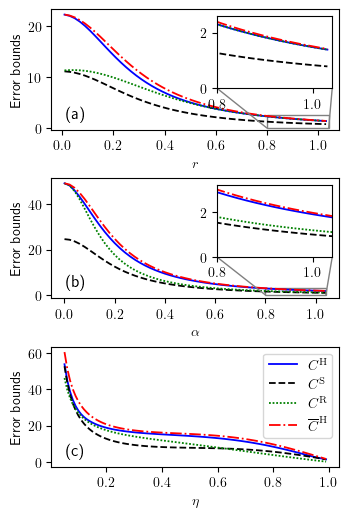

In [ ]:
fig = plt.figure(figsize=(3.375,3.375*1.5),layout='constrained')
axs = fig.subplots(3,1)


m = 1 #number of modes
dim = 2*m
pi = math.pi
npar = 2

### First panel

Realpha = 0.3
Imalpha= 0
fi=pi/6
eta=0.5

r_values = []
holCRB_values = []
sldCRB_values = []
rldCRB_values = []
upper_values = []
status_values = []
Zopt_values = [] 

for r_value in np.arange(0.01, 1.05, 0.02):
    r = r_value
    
    eps=1.0000001

    sigma = eps*np.array([[(eta*(np.exp(2*r)*np.cos(fi)*np.cos(fi)+np.exp(-2*r)*np.sin(fi)*np.sin(fi))+1-eta), eta*(-np.exp(2*r)*np.sin(fi)*np.cos(fi)+np.exp(-2*r)*np.sin(fi)*np.cos(fi))], [eta*(-np.exp(2*r)*np.sin(fi)*np.cos(fi)+np.exp(-2*r)*np.sin(fi)*np.cos(fi)),(eta*(np.exp(2*r)*np.sin(fi)*np.sin(fi)+np.exp(-2*r)*np.cos(fi)*np.cos(fi))+1-eta)]])
    rmean = np.array([np.sqrt(2*eta)*(Realpha*np.cos(fi)+Imalpha*np.sin(fi)),np.sqrt(2*eta)*(-Realpha*np.sin(fi)+Imalpha*np.cos(fi))])

    dsigma = np.zeros((dim, dim, npar))
    drmean = np.zeros((dim,npar))

    dsigma[:, :, 0] = np.array([[-2*eta*np.sin(2*fi)*np.sinh(2*r),-2*eta*np.cos(2*fi)*np.sinh(2*r)], [-2*eta*np.cos(2*fi)*np.sinh(2*r),2*eta*np.sin(2*fi)*np.sinh(2*r)]])
    dsigma[:, :, 1] = np.array([[np.exp(2*r)*np.cos(fi)*np.cos(fi)+np.exp(-2*r)*np.sin(fi)*np.sin(fi)-1,-np.sin(2*fi)*np.sinh(2*r)], [-np.sin(2*fi)*np.sinh(2*r),np.exp(2*r)*np.sin(fi)*np.sin(fi)+np.exp(-2*r)*np.cos(fi)*np.cos(fi)-1]])

    drmean[:, 0] = np.array([np.sqrt(2*eta)*(Imalpha*np.cos(fi)-Realpha*np.sin(fi)),-np.sqrt(2*eta)*(Realpha*np.cos(fi)+Imalpha*np.sin(fi))])
    drmean[:, 1] = np.array([(Realpha*np.cos(fi)+Imalpha*np.sin(fi))/np.sqrt(2*eta),(Imalpha*np.cos(fi)-Realpha*np.sin(fi))/np.sqrt(2*eta)])

    
    holCRB, status, Zopt  = gauss_hcrb_SDP(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
    sldCRB  = gauss_SLDB(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
    rldCRB  = gauss_RLDB(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
    upper = gauss_upper(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
    
    r_values.append(r)
    holCRB_values.append(holCRB)
    status_values.append(status)
    Zopt_values.append(Zopt)
    sldCRB_values.append(sldCRB)
    rldCRB_values.append(rldCRB)
    upper_values.append(upper)    


axs[0].plot(r_values, holCRB_values,marker='none',color='b', label=r'$C^{\mathrm{H}}$')
axs[0].plot(r_values, sldCRB_values, marker='none', linestyle='dashed', color='k', label=r'$C^{\mathrm{S}}$')
axs[0].plot(r_values, rldCRB_values, marker='none', linestyle=(0, (1, 1)), color='g', label=r'$C^{\mathrm{R}}$')
axs[0].plot(r_values, upper_values, marker='none', color='r', linestyle='dashdot', label=r'$\overline{C}^{\mathrm{H}}$')  
axs[0].set_xlabel(r'$r$')
axs[0].set_ylabel('Error bounds')

# Inset axis
axins0 = inset_axes(axs[0], width="40%", height="60%", loc='upper right')

# Plot the same data in the inset
axins0.plot(r_values, holCRB_values, marker='none', color='b')
axins0.plot(r_values, sldCRB_values, marker='none', linestyle='dashed', color='k')
axins0.plot(r_values, rldCRB_values, marker='none', linestyle=(0, (1, 1)), color='g')
axins0.plot(r_values, upper_values, marker='none', linestyle='dashdot', color='r')

# Set zoom limits
axins0.set_xlim(0.8, 1.04)
axins0.set_ylim(0,2.6)  # optional, adjust if necessary

# Connect inset to the main plot
mark_inset(axs[0], axins0, loc1=3, loc2=4, fc="none", ec="0.5")

### Second panel

Imalpha= 0

eta=0.5
r=0.2

Realpha_values = []
holCRB_values = []
sldCRB_values = []
rldCRB_values = []
upper_values = []
status_values = []
Zopt_values = [] 

for Realpha_value in np.arange(0.001, 1.05, 0.02):
    Realpha = Realpha_value
    
    eps=1.00001

    sigma = eps*np.array([[(eta*(np.exp(2*r)*np.cos(fi)*np.cos(fi)+np.exp(-2*r)*np.sin(fi)*np.sin(fi))+1-eta), eta*(-np.exp(2*r)*np.sin(fi)*np.cos(fi)+np.exp(-2*r)*np.sin(fi)*np.cos(fi))], [eta*(-np.exp(2*r)*np.sin(fi)*np.cos(fi)+np.exp(-2*r)*np.sin(fi)*np.cos(fi)),(eta*(np.exp(2*r)*np.sin(fi)*np.sin(fi)+np.exp(-2*r)*np.cos(fi)*np.cos(fi))+1-eta)]])
    rmean = np.array([np.sqrt(2*eta)*(Realpha*np.cos(fi)+Imalpha*np.sin(fi)),np.sqrt(2*eta)*(-Realpha*np.sin(fi)+Imalpha*np.cos(fi))])

    dsigma = np.zeros((dim, dim, npar))
    drmean = np.zeros((dim,npar))

    dsigma[:, :, 0] = np.array([[-2*eta*np.sin(2*fi)*np.sinh(2*r),-2*eta*np.cos(2*fi)*np.sinh(2*r)], [-2*eta*np.cos(2*fi)*np.sinh(2*r),2*eta*np.sin(2*fi)*np.sinh(2*r)]])
    dsigma[:, :, 1] = np.array([[np.exp(2*r)*np.cos(fi)*np.cos(fi)+np.exp(-2*r)*np.sin(fi)*np.sin(fi)-1,-np.sin(2*fi)*np.sinh(2*r)], [-np.sin(2*fi)*np.sinh(2*r),np.exp(2*r)*np.sin(fi)*np.sin(fi)+np.exp(-2*r)*np.cos(fi)*np.cos(fi)-1]])

    drmean[:, 0] = np.array([np.sqrt(2*eta)*(Imalpha*np.cos(fi)-Realpha*np.sin(fi)),-np.sqrt(2*eta)*(Realpha*np.cos(fi)+Imalpha*np.sin(fi))])
    drmean[:, 1] = np.array([(Realpha*np.cos(fi)+Imalpha*np.sin(fi))/np.sqrt(2*eta),(Imalpha*np.cos(fi)-Realpha*np.sin(fi))/np.sqrt(2*eta)])

    
    holCRB, status, Zopt  = gauss_hcrb_SDP(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
    sldCRB  = gauss_SLDB(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
    rldCRB  = gauss_RLDB(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
    upper = gauss_upper(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
    
    Realpha_values.append(Realpha)
    holCRB_values.append(holCRB)
    status_values.append(status)
    Zopt_values.append(Zopt)
    sldCRB_values.append(sldCRB)
    rldCRB_values.append(rldCRB)
    upper_values.append(upper)

axs[1].plot(Realpha_values, holCRB_values,marker='none',color='b', label=r'$C^{\mathrm{H}}$')
axs[1].plot(Realpha_values, sldCRB_values, marker='none', linestyle='dashed', color='k', label=r'$C^{\mathrm{S}}$')
axs[1].plot(Realpha_values, rldCRB_values, marker='none', linestyle=(0, (1, 1)), color='g', label=r'$C^{\mathrm{R}}$')
axs[1].plot(Realpha_values, upper_values, marker='none', color='r', linestyle='dashdot', label=r'$\overline{C}^{\mathrm{H}}$')  
axs[1].set_xlabel(r'$\alpha$')
axs[1].set_ylabel('Error bounds')


# Inset axis
axins = inset_axes(axs[1], width="40%", height="60%", loc='upper right')

# Plot the same data in the inset
axins.plot(Realpha_values, holCRB_values, marker='none', color='b')
axins.plot(Realpha_values, sldCRB_values, marker='none', linestyle='dashed', color='k')
axins.plot(Realpha_values, rldCRB_values, marker='none', linestyle=(0, (1, 1)), color='g')
axins.plot(Realpha_values, upper_values, marker='none', linestyle='dashdot', color='r')

# Set zoom limits
axins.set_xlim(0.8, 1.04)
axins.set_ylim(0,3.2)  # optional, adjust if necessary

# Connect inset to the main plot
mark_inset(axs[1], axins, loc1=3, loc2=4, fc="none", ec="0.5")

### Third panel

Realpha = 0.3
Imalpha= 0
fi=pi/6
r=0.2

eta_values = []
holCRB_values = []
sldCRB_values = []
rldCRB_values = []
upper_values = []
status_values = []
Zopt_values = [] 

for eta_value in np.arange(0.05, 0.999, 0.01):
    eta = eta_value
    
    eps=1.0001

    sigma = eps*np.array([[(eta*(np.exp(2*r)*np.cos(fi)*np.cos(fi)+np.exp(-2*r)*np.sin(fi)*np.sin(fi))+1-eta), eta*(-np.exp(2*r)*np.sin(fi)*np.cos(fi)+np.exp(-2*r)*np.sin(fi)*np.cos(fi))], [eta*(-np.exp(2*r)*np.sin(fi)*np.cos(fi)+np.exp(-2*r)*np.sin(fi)*np.cos(fi)),(eta*(np.exp(2*r)*np.sin(fi)*np.sin(fi)+np.exp(-2*r)*np.cos(fi)*np.cos(fi))+1-eta)]])
    rmean = np.array([np.sqrt(2*eta)*(Realpha*np.cos(fi)+Imalpha*np.sin(fi)),np.sqrt(2*eta)*(-Realpha*np.sin(fi)+Imalpha*np.cos(fi))])

    dsigma = np.zeros((dim, dim, npar))
    drmean = np.zeros((dim,npar))

    dsigma[:, :, 0] = np.array([[-2*eta*np.sin(2*fi)*np.sinh(2*r),-2*eta*np.cos(2*fi)*np.sinh(2*r)], [-2*eta*np.cos(2*fi)*np.sinh(2*r),2*eta*np.sin(2*fi)*np.sinh(2*r)]])
    dsigma[:, :, 1] = np.array([[np.exp(2*r)*np.cos(fi)*np.cos(fi)+np.exp(-2*r)*np.sin(fi)*np.sin(fi)-1,-np.sin(2*fi)*np.sinh(2*r)], [-np.sin(2*fi)*np.sinh(2*r),np.exp(2*r)*np.sin(fi)*np.sin(fi)+np.exp(-2*r)*np.cos(fi)*np.cos(fi)-1]])

    drmean[:, 0] = np.array([np.sqrt(2*eta)*(Imalpha*np.cos(fi)-Realpha*np.sin(fi)),-np.sqrt(2*eta)*(Realpha*np.cos(fi)+Imalpha*np.sin(fi))])
    drmean[:, 1] = np.array([(Realpha*np.cos(fi)+Imalpha*np.sin(fi))/np.sqrt(2*eta),(Imalpha*np.cos(fi)-Realpha*np.sin(fi))/np.sqrt(2*eta)])

    
    holCRB, status, Zopt  = gauss_hcrb_SDP(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
    sldCRB  = gauss_SLDB(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
    rldCRB  = gauss_RLDB(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
    upper = gauss_upper(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
    
    eta_values.append(eta)
    holCRB_values.append(holCRB)
    status_values.append(status)
    Zopt_values.append(Zopt)
    sldCRB_values.append(sldCRB)
    rldCRB_values.append(rldCRB)
    upper_values.append(upper)

axs[2].plot(eta_values, holCRB_values,marker='none',color='b', label=r'$C^{\mathrm{H}}$')
axs[2].plot(eta_values, sldCRB_values, marker='none', linestyle='dashed', color='k', label=r'$C^{\mathrm{S}}$')
axs[2].plot(eta_values, rldCRB_values, marker='none', linestyle=(0, (1, 1)), color='g', label=r'$C^{\mathrm{R}}$')
axs[2].plot(eta_values, upper_values, marker='none', color='r', linestyle='dashdot', label=r'$\overline{C}^{\mathrm{H}}$')  
axs[2].set_xlabel(r'$\eta$')
axs[2].set_ylabel('Error bounds')

axs[2].legend()

axs[0].text(0.05, 0.1, '(a)', transform=axs[0].transAxes, fontsize=12);
axs[1].text(0.05, 0.1, '(b)', transform=axs[1].transAxes, fontsize=12);
axs[2].text(0.05, 0.1, '(c)', transform=axs[2].transAxes,  fontsize=12);

## Squeezing and displacement estimation

/opt/homebrew/Caskroom/miniforge/base/envs/quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/quantum/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


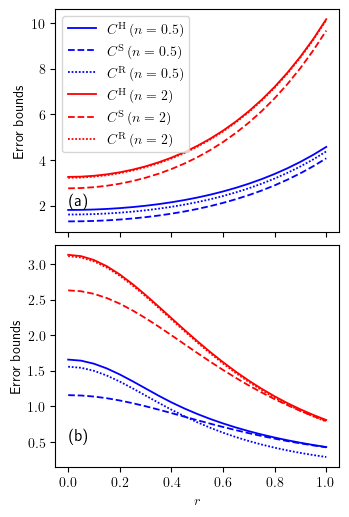

In [10]:
fig = plt.figure(figsize=(3.375,3.375*1.5),layout='constrained')
axs = fig.subplots(2,1,sharex=True)

Realpha = 0.3
Imalpha = 0.2
dim = 2
npar = 3

r_values = np.arange(0, 1.05, 0.05)
n_values = [0.5, 2]

results = {n: {'holCRB': [], 'sldCRB': [], 'rldCRB': []} for n in n_values}

for n in n_values:
    for r in r_values:
        epsTh = 1.0000001

        sigma = epsTh*(2*n+1)*np.array([[np.exp(2*r), 0],[0, np.exp(-2*r)]])
        rmean = np.array([np.sqrt(2)*Realpha,np.sqrt(2)*Imalpha])

        dsigma = np.zeros((dim, dim, npar))
        drmean = np.zeros((dim,npar))

        dsigma[:, :, 0] = epsTh*np.array([[0, 0], [0, 0]])
        dsigma[:, :, 1] = epsTh*np.array([[0, 0], [0, 0]])
        dsigma[:, :, 2] = epsTh*(2*n+1)*np.array([[2*np.exp(2*r),0],[0,-2*np.exp(-2*r)]])

        drmean[:, 0] = np.array([np.sqrt(2), 0])
        drmean[:, 1] = np.array([0, np.sqrt(2)])
        drmean[:, 2] = np.array([0, 0])

        holCRB, status, Zopt = gauss_hcrb_SDP(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
        sldCRB = gauss_SLDB(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
        rldCRB = gauss_RLDB(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)

        results[n]['holCRB'].append(holCRB)
        results[n]['sldCRB'].append(sldCRB)
        results[n]['rldCRB'].append(rldCRB)

colors = ['b', 'r', 'g', 'c']
markers = ['o', 's', '^', 'd']
labels = ['HCRB, Upper bound', 'SLD', 'RLD']

for i, n in enumerate(n_values):
    axs[0].plot(r_values, results[n]['holCRB'], color=colors[i], marker='none', linestyle='-', label=fr'$C^{{\mathrm{{H}}}}\,(n={n})$')
    axs[0].plot(r_values, results[n]['sldCRB'], color=colors[i],  marker='none',linestyle='--', label=fr'$C^{{\mathrm{{S}}}}\,(n={n})$')
    axs[0].plot(r_values, results[n]['rldCRB'], color=colors[i],  marker='none', linestyle=(0, (1, 1)), label=fr'$C^{{\mathrm{{R}}}}\,(n={n})$')

axs[0].set_ylabel('Error bounds')
axs[0].legend()


### Second panel 

Realpha = 0.5
Imalpha = 0.2
dim = 4
npar = 3

r_values = np.arange(0, 1.05, 0.05)
n_values = [0.5,2]

results = {n: {'holCRB': [], 'sldCRB': [], 'rldCRB': [], 'upper': []} for n in n_values}

for n in n_values:
    for r in r_values:
        epsTh = 1.00000000001

        sigma = epsTh *(2*n+1)*np.array([[np.exp(2*r),0,0,0], [0,np.exp(-2*r),0,0],[0,0,np.exp(-2*r),0],[0,0,0,np.exp(2*r)]])
        rmean = np.array([Realpha,Imalpha,-Realpha,-Imalpha])

        dsigma = np.zeros((dim, dim, npar))
        drmean = np.zeros((dim,npar))

        dsigma[:, :, 0] = epsTh*np.array([[0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]])
        dsigma[:, :, 1] = epsTh*np.array([[0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]])
        dsigma[:, :, 2] = epsTh*(2*n+1)*np.array([[2*np.exp(2*r),0,0,0],[0,-2*np.exp(-2*r),0,0],[0,0,-2*np.exp(-2*r),0],[0,0,0,2*np.exp(2*r)]])

        drmean[:, 0] = np.array([1,0,-1,0])
        drmean[:, 1] = np.array([0,1,0,-1])
        drmean[:, 2] = np.array([0,0,0,0])

        holCRB, status, Zopt = gauss_hcrb_SDP(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
        sldCRB = gauss_SLDB(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
        rldCRB = gauss_RLDB(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)
        upper =gauss_upper(sigma, rmean, dsigma, drmean, npar, np.eye(npar), tol=1.0e-8)

        results[n]['holCRB'].append(holCRB)
        results[n]['sldCRB'].append(sldCRB)
        results[n]['rldCRB'].append(rldCRB)
        results[n]['upper'].append(upper)


for i, n in enumerate(n_values):
    axs[1].plot(r_values, results[n]['holCRB'], color=colors[i], marker='none', linestyle='-', label=fr'$C^{{\mathrm{{H}}}} = \\bar{{C}}^{{\mathrm{{H}}}}\,(n={n})$')
    axs[1].plot(r_values, results[n]['sldCRB'], color=colors[i],  marker='none',linestyle='--', label=fr'$C^{{\mathrm{{S}}}}\,(n={n})$')
    axs[1].plot(r_values, results[n]['rldCRB'], color=colors[i],  marker='none', linestyle=(0, (1, 1)), label=fr'$C^{{\mathrm{{R}}}}\,(n={n})$')

axs[1].set_xlabel(r'$r$')
axs[1].set_ylabel('Error bounds')

axs[0].text(0.05, 0.12, '(a)', transform=axs[0].transAxes,fontsize=12);
axs[1].text(0.05, 0.12, '(b)', transform=axs[1].transAxes,fontsize=12);

# 📋 System and environment information (for reproducibility)

In [15]:
import sys
import platform

# Jupyter version
try:
    import notebook
    jupyter_version = notebook.__version__
except ImportError:
    try:
        import jupyter_core
        jupyter_version = jupyter_core.__version__
    except ImportError:
        jupyter_version = "Not installed"

# IPython version
try:
    import IPython
    ipython_version = IPython.__version__
except ImportError:
    ipython_version = "Not installed"

print("System Info Summary")
print("-------------------")
print("Python Version     :", sys.version.split()[0])
print("Platform           :", platform.platform())
print("Architecture       :", platform.machine())
print("NumPy Version      :", np.__version__)
print("Matplotlib Version :", mpl.__version__)
print("IPython Version    :", ipython_version)
print("Jupyter Version    :", jupyter_version)

System Info Summary
-------------------
Python Version     : 3.11.8
Platform           : macOS-14.7.4-arm64-arm-64bit
Architecture       : arm64
NumPy Version      : 1.26.4
Matplotlib Version : 3.7.3
IPython Version    : 8.22.1
Jupyter Version    : 7.1.1
